In [2]:
%pip install pandas 
%pip install python-dotenv
%pip install -U scikit-learn
%pip install sun_position_calculator
%pip install requests
%pip install docxtpl
%pip install matplotlib
%pip install tabulate
%pip install pyxirr
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
#local models
from typing import Dict
from models.econometrics import Cost, Currency
from models.components import Component
from models.econometrics import Cost
from models.geometry import Orientation
from models.photovoltaic import Photovoltaic
import pandas as pd

In [4]:
#local env variables
from dotenv import dotenv_values
config = dotenv_values(".env.local")

# Building references

## Currencies values

In [5]:
import requests # type: ignore
import json
#currency values

# national units https://mindicador.cl/api
query_factor:requests.Response = requests.get('https://mindicador.cl/api',timeout=1000)
ratios_cl = json.loads(query_factor.text)
usd_clp:float = ratios_cl['dolar']['valor']
Cost.set_exchange(Currency.CLP,usd_clp)
Cost.set_exchange(Currency.UF,usd_clp/ratios_cl['uf']['valor']) # 1 dolar in UF
Cost.set_exchange(Currency.UTM,usd_clp/ratios_cl['utm']['valor']) # 1 dolar in Utm

# exchange rates https://app.freecurrencyapi.com/dashboard
query_exchange:requests.Response = requests.get(config["CURRENCY_API_KEY"],timeout=1000)

currency_ratios = json.loads(query_exchange.text)
Cost.set_exchange(Currency.EUR,currency_ratios['data']['EUR'])
Cost.set_exchange(Currency.GBP,currency_ratios['data']['GBP'])
Cost.set_exchange(Currency.BRL,currency_ratios['data']['BRL'])


set $1 Peso Chileno... on USD$0.00 
set $1 UF............. on USD$39.74 
set $1 UTM............ on USD$69.75 
set $1 Euro........... on USD$1.08 
set $1 Pound.......... on USD$1.25 
set $1 Real........... on USD$0.20 


## Address and general info🌎

In [6]:
#cspell:disable


#init proyect
from models.components import Tech
from models.geometry import GeoPosition
from models.inventory import Building, Project

project:Project = Project(
    title='Sistema Fotovoltaico OnGrid-Mixto',
    building = Building(
        geolocation=GeoPosition(latitude=-33.861702,longitude=-71.657839),
        name='Posta de Salud Rural Bucalemu',
        address='Ruta G-80-I km 30 sn, Localidad Bucalemu,\nSanto Domingo',
        city='Santo Domingo'),
    technology= [Tech.PHOTOVOLTAIC]
    )

api request URL https://power.larc.nasa.gov/api/temporal/hourly/point?Time=LST&parameters=T2M,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_SRF_ALB,SZA,WS10M&community=RE&latitude=-33.861702&longitude=-71.657839&start=20230101&end=20231231&format=JSON


# Integration 

## Energy Consumptions🔌

In [7]:
from models.consumption import ElectricityBill, Energetic
project.building.add_consumptions(description="main",energetic=Energetic.ELI,consumption=[
    ElectricityBill(450,"30-12-2022",cost=71400),
    ElectricityBill(497,"30-01-2023",cost=80800),
    ElectricityBill(450,"28-02-2023",cost=71400),
    ElectricityBill(475,"30-03-2023",cost=77400),
    ElectricityBill(475,"30-04-2023",cost=77400),
    ElectricityBill(520,"30-05-2023",cost=93400),
    ElectricityBill(654,"30-06-2023",cost=122100),
    ElectricityBill(820,"30-07-2023",cost=140800),
    ElectricityBill(549,"31-10-2023",cost=100000),
])



In [8]:
#project.building.consumptions['main'].forecast()
#project.building.consumption_forecast(['main','sec'])

from pandas import DataFrame


COST_INCREMENT = 0.07
forecast:DataFrame = project.building.consumptions['main'].forecast(cost_increment=COST_INCREMENT)
base = pd.DataFrame.from_dict(project.building.consumptions['main'].base())


boundaries in month 8 : 820 <-> 549
boundaries in month 9 : 684.5 <-> 549
boundaries in month 11 : 549 <-> 450


## Machine Components 🎡

In [9]:
#cspell: disable

#clean previous load
project.components = {}
from IPython.display import clear_output

from models.photovoltaic import Length, PvTechnicalSheet
clear_output(wait=True)

# assembly projects components
project.add_component(
    'generación',
    Photovoltaic(project.weather,'Módulo Primario FV A',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Solar Panel PV 650W 48V',
                quantity=3,
                cost=None,
                orientation=Orientation(15,270-16.46),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM)),
                ),
    Photovoltaic(project.weather,'Módulo Secundario FV B',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Solar Panel 650W 48V',
                quantity=4,
                cost=None,
                orientation=Orientation(15,16.46),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM)),
                ),
    generator=True
    )

project.add_component(
    'auxiliar',
    Component('Inversor Híbrido',
                model='Voltronic 5kW 48V',
                reference='https://solarbex.com/comprar/inversor-hibrido-5kw-48v-axpert/',
                specification='Híbrido 5kW Monofásico',
                cost_per_unit=Cost(869,Currency.EUR)),
    Component('Controlador de Carga',
                model='Enertik 80A 12/24V',
                specification='1000W to 2000 24V output',
                cost_per_unit=Cost(101600,Currency.CLP)),
    Component('medidor bidireccional',
                model='Elster AS1440',
                specification='Trifasico',
                cost_per_unit=Cost(306990,Currency.CLP)),
    Component('almacenamiento',
                model='MP NP12-200',
                specification='Batería 12V 200Ah',
                reference='https://www.tiendatecnored.cl/bateria-gel-ciclo-profundo-12v-200ah.html',
                cost_per_unit=Cost(204889,Currency.CLP),
                quantity=4,
                )
    )

project.add_component(
    'obras',
    Component(description='instalación eléctrica',
            specification='H/P eléctrico',
            cost_per_unit=Cost(1,currency=Currency.UF),
            quantity=8*5,
            ),
    Component(description='estructura de soporte',
            specification='elementos fijación',
            cost_per_unit=Cost((4*800+11400/4+4*700+4000+500)),
            quantity=24
            )
)


inside cost pv :  245990.0 Currency.CLP
inside cost pv :  245990.0 Currency.CLP


In [10]:
# psr_bucalemu.components['generación'][1].nominal_power()
#pv_log_model(1500) #clp/w

bucket = project.bucket_list(Currency.CLP)
bucket_df:DataFrame = bucket['bucket']


In [11]:
# psr_bucalemu.get_energy_generation('generación')
project.energy_production()#[['month','day','System_capacity_KW']].groupby(['month','day'],as_index=False).sum()
production_array = list(map(lambda it:f'{it['System_capacity_KW'].sum():.2f} kWh',project.production_array()))

In [12]:
#performance

performance = project.performance(consumptions=['main'],cost_increment=7/100)
production_performance = performance[['month','consumption','generation','netbilling','savings']]
benefits_performance = performance[['month','unit_cost','benefits']]
performance

boundaries in month 8 : 820 <-> 549
boundaries in month 9 : 684.5 <-> 549
boundaries in month 11 : 549 <-> 450


,month,consumption,unit_cost,generation,netbilling,savings,benefits,CO2 kg
0,1,497.00,213.103897,878.189085,381.189085,497.000000,105912.636806,178.945244
1,2,450.00,210.276443,717.761389,267.761389,450.000000,94624.399188,146.255504
2,3,475.00,211.780408,637.832747,162.832747,475.000000,100595.693668,129.968749
3,4,475.00,211.780408,436.502148,0.000000,436.502148,92442.602914,88.944380
4,5,520.00,214.487545,309.998897,0.000000,309.998897,66490.902276,63.167294
5,6,654.00,222.548798,260.058021,0.000000,260.058021,57875.599952,52.991032
6,7,820.00,232.535126,284.399497,0.000000,284.399497,66132.872810,57.951002
7,8,684.50,224.383635,344.867837,0.000000,344.867837,77382.699001,70.272405
8,9,616.75,220.307890,466.889274,0.000000,466.889274,102859.390772,95.136249
9,10,549.00,216.232144,643.742354,94.742354,549.000000,118711.447256,131.172927


## Saving results on EXCEL ❎

In [13]:
data_to_file:dict[str,DataFrame] = {
    'clima':project.weather.get_data(),
    'capacidad':project.energy_production(),
    'performance':performance,
}

for key,data in data_to_file.items():
    with pd.ExcelWriter(f'build/calc_{project.building.city}_{project.building.name}_{key}.xlsx') as writer:
        data.to_excel(writer,sheet_name='result')

# Write Document 📒


In [14]:
from docxtpl import DocxTemplate,RichText
from datetime import datetime
from uuid import uuid1
#init doc
#assembly proxy object 
doc = DocxTemplate("templates/memory_template.docx")

## Write params and tables

In [15]:
#hyperlinks
gmaps = RichText()
gmaps.add('ver maps',url_id=doc.build_url_id(project.weather.geo_position.gmaps),bold=True,underline=True)

In [16]:
#loading context
#cspell: disable
ctx:dict[str,any] = {
    #report
    "report_date":datetime.now().strftime("%a, %d de %B %Y"),
    "report_version":"ver."+str(uuid1()).split('-')[0],
    #site
    "project":project,
    "gmaps":gmaps,
    
    #about this project
    "project_type" : project.technology[0].value.capitalize(),
    "project_size":f"{project.nominal_power[0]:.2f} kW",
    "total_cost": f"CLP$ {project.bucket_list(Currency.CLP)["cost"]:,.0f}",
    #benefits
    "annual_benefits": f"CLP$ {performance['benefits'].sum():,.0f}",
    "energy_production": f"{performance['generation'].sum():.0f} kWh/año",
    "energy_netbilling": f"{performance['netbilling'].sum():.0f} kWh/año",
    "energy_savings": f"{performance['savings'].sum():.0f} kWh/año",
    #emissions
    "emission_reduction":f"{performance['CO2 kg'].sum():,.2f} kg CO2",
    "emission_forecast":f'{project.emissions.annual_projection(2024):.4f} Ton CO2/MWh',
    "table_emission_historic":project.emissions.annual_avg().round(4).to_markdown(index=False),
    "table_emission_reduction":performance[['month','CO2 kg']].round(2).rename(columns={'month':'mes'}).to_markdown(index=False),
    
    #consumptions
        ##base
    "table_base_consumptions":
        base.rename(columns={
                "energy": "proyectado kWh",
                "month":'mes',
                'unit_cost':'costo $CLP/kWh'
                }).to_markdown(index=False),
        ##projected or future
    "cost_increment":f"{COST_INCREMENT*100:.2f} %",
    "forecast_consumption":f"{forecast['energy'].sum()} kWh/año",
    "table_forecast_consumptions":
        forecast.rename(columns={
                "energy": "proyectado kWh",
                "month":'mes',
                'unit_cost':'costo $CLP/kWh'
                }).to_markdown(index=False),
    #components
    "table_components":bucket_df
            [['description','details','quantity','cost_after_tax']]
            .rename(columns={
                'description':'descripción',
                'details':'técnico',
                'quantity':'cantidad',
                'cost_after_tax':'costo bruto'
            })
            .to_markdown(index=False),
    "table_energy_components":bucket_df[bucket_df['gloss']=='generación'][['description','details','quantity']]
    .rename(columns={
                'description':'descripción',
                'details':'detalle',
                'quantity':'cantidad'
            })
    .to_markdown(index=False),
    #production
    "table_production_array":production_array,
    "table_production_performance":production_performance
    .rename(columns={
            'month':'mes',
            'consumption':'demanda',
            'generation':'generación',
            'savings':'ahorro',
            }).round(2).to_markdown(index=False),
    #economics
    "eco":project.economical_analysis(Currency.CLP,format=True),
    "eco_num":project.economical_analysis(Currency.CLP,format=False),

}
#render to doc
doc.render(ctx)

#ctx#project.get_context('generación')

## Insert Plots 📊

In [17]:
#dep
import matplotlib.pyplot as plt
PATH = 'build/'

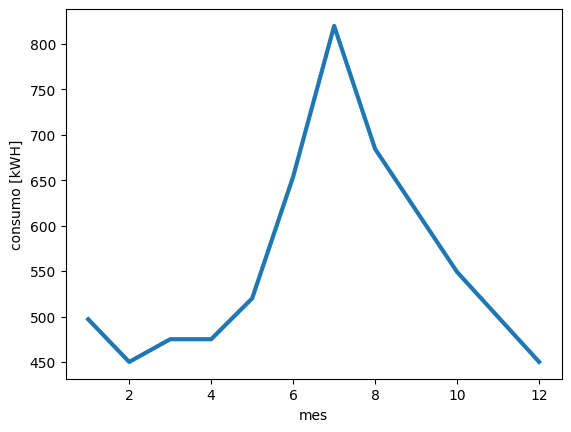

In [18]:
#plot_consumption_forecast
p = plt.subplot()
p.plot(forecast['month'],forecast['energy'],linewidth=3)
p.set_xlabel('mes'), p.set_ylabel('consumo [kWH]')
plt.savefig(PATH+'plot_consumption_forecast'+'.png',dpi=300)

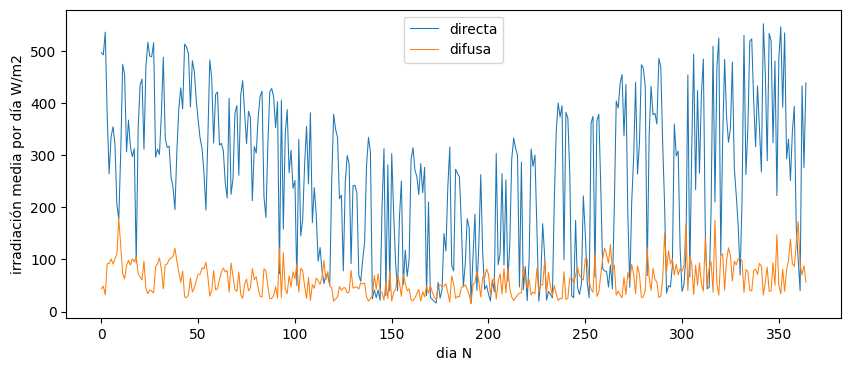

In [19]:
# plot_irradiance
plt.figure(figsize=(10,4))
p = plt.subplot()
w = project.weather.get_data()
g= w[['month','day','ALLSKY_SFC_SW_DNI','ALLSKY_SFC_SW_DIFF']].groupby(['month','day'],as_index=False).mean()
p.plot(
    g.index.values,
    g['ALLSKY_SFC_SW_DNI'].values,
    label='directa',
    linewidth=.75
    )
p.plot(
    g.index.values,
    g['ALLSKY_SFC_SW_DIFF'].values,
    label='difusa',
    linewidth=.75
    )
p.set_xlabel('dia N'), p.set_ylabel('irradiación media por día W/m2')
plt.legend()
plt.savefig(PATH+'plot_irradiance'+'.png',dpi=350)


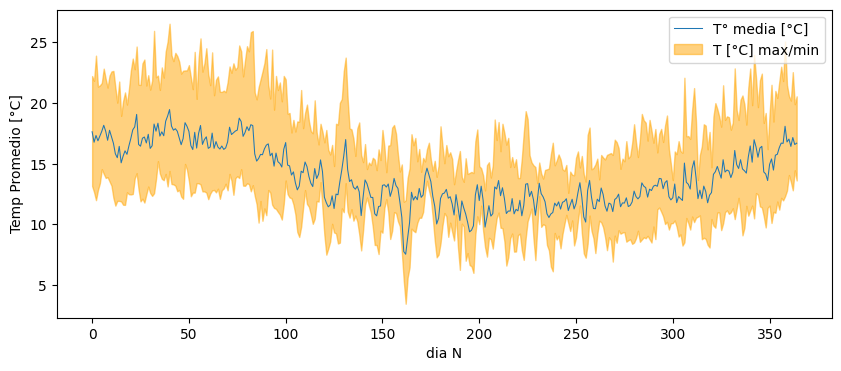

In [20]:
# plot_temperature
plt.figure(figsize=(10,4))
p = plt.subplot()
w = project.weather.get_data()
g_max= w[['month','day','T2M',]].groupby(['month','day'],as_index=False).max()
g_min= w[['month','day','T2M',]].groupby(['month','day'],as_index=False).min()
g_men= w[['month','day','T2M',]].groupby(['month','day'],as_index=False).mean()
p.plot(
    g_men.index,
    g_men['T2M'],
    label='T° media [°C]',
    linewidth=.75,
    )
p.fill_between(
    g_men.index,
    g_max['T2M'],
    g_min['T2M'],
    alpha=.5,
    color='orange',
    label='T [°C] max/min'
    )

p.set_xlabel('dia N'), p.set_ylabel('Temp Promedio [°C]')
plt.legend()
plt.savefig(PATH+'plot_temperature'+'.png',dpi=350)

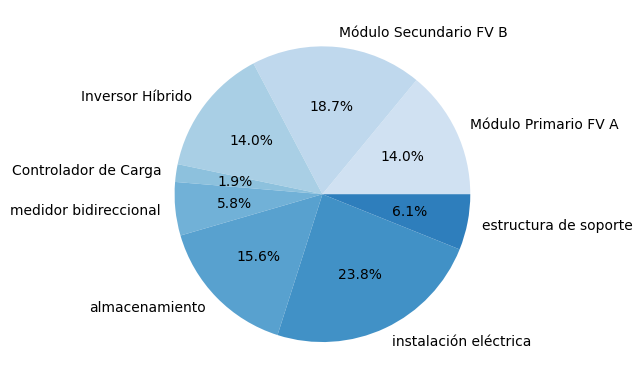

In [21]:
#plot_components
import numpy as np


p = plt.subplot()
colors = plt.get_cmap('Blues')(np.linspace(0.2, 0.7, bucket_df.index.size))
p.pie(
    bucket_df['cost_after_tax'],
    labels = bucket_df['description'],
    colors=colors,
    autopct='%1.1f%%'
    )

plt.savefig(PATH+'plot_components'+'.png',dpi=300)

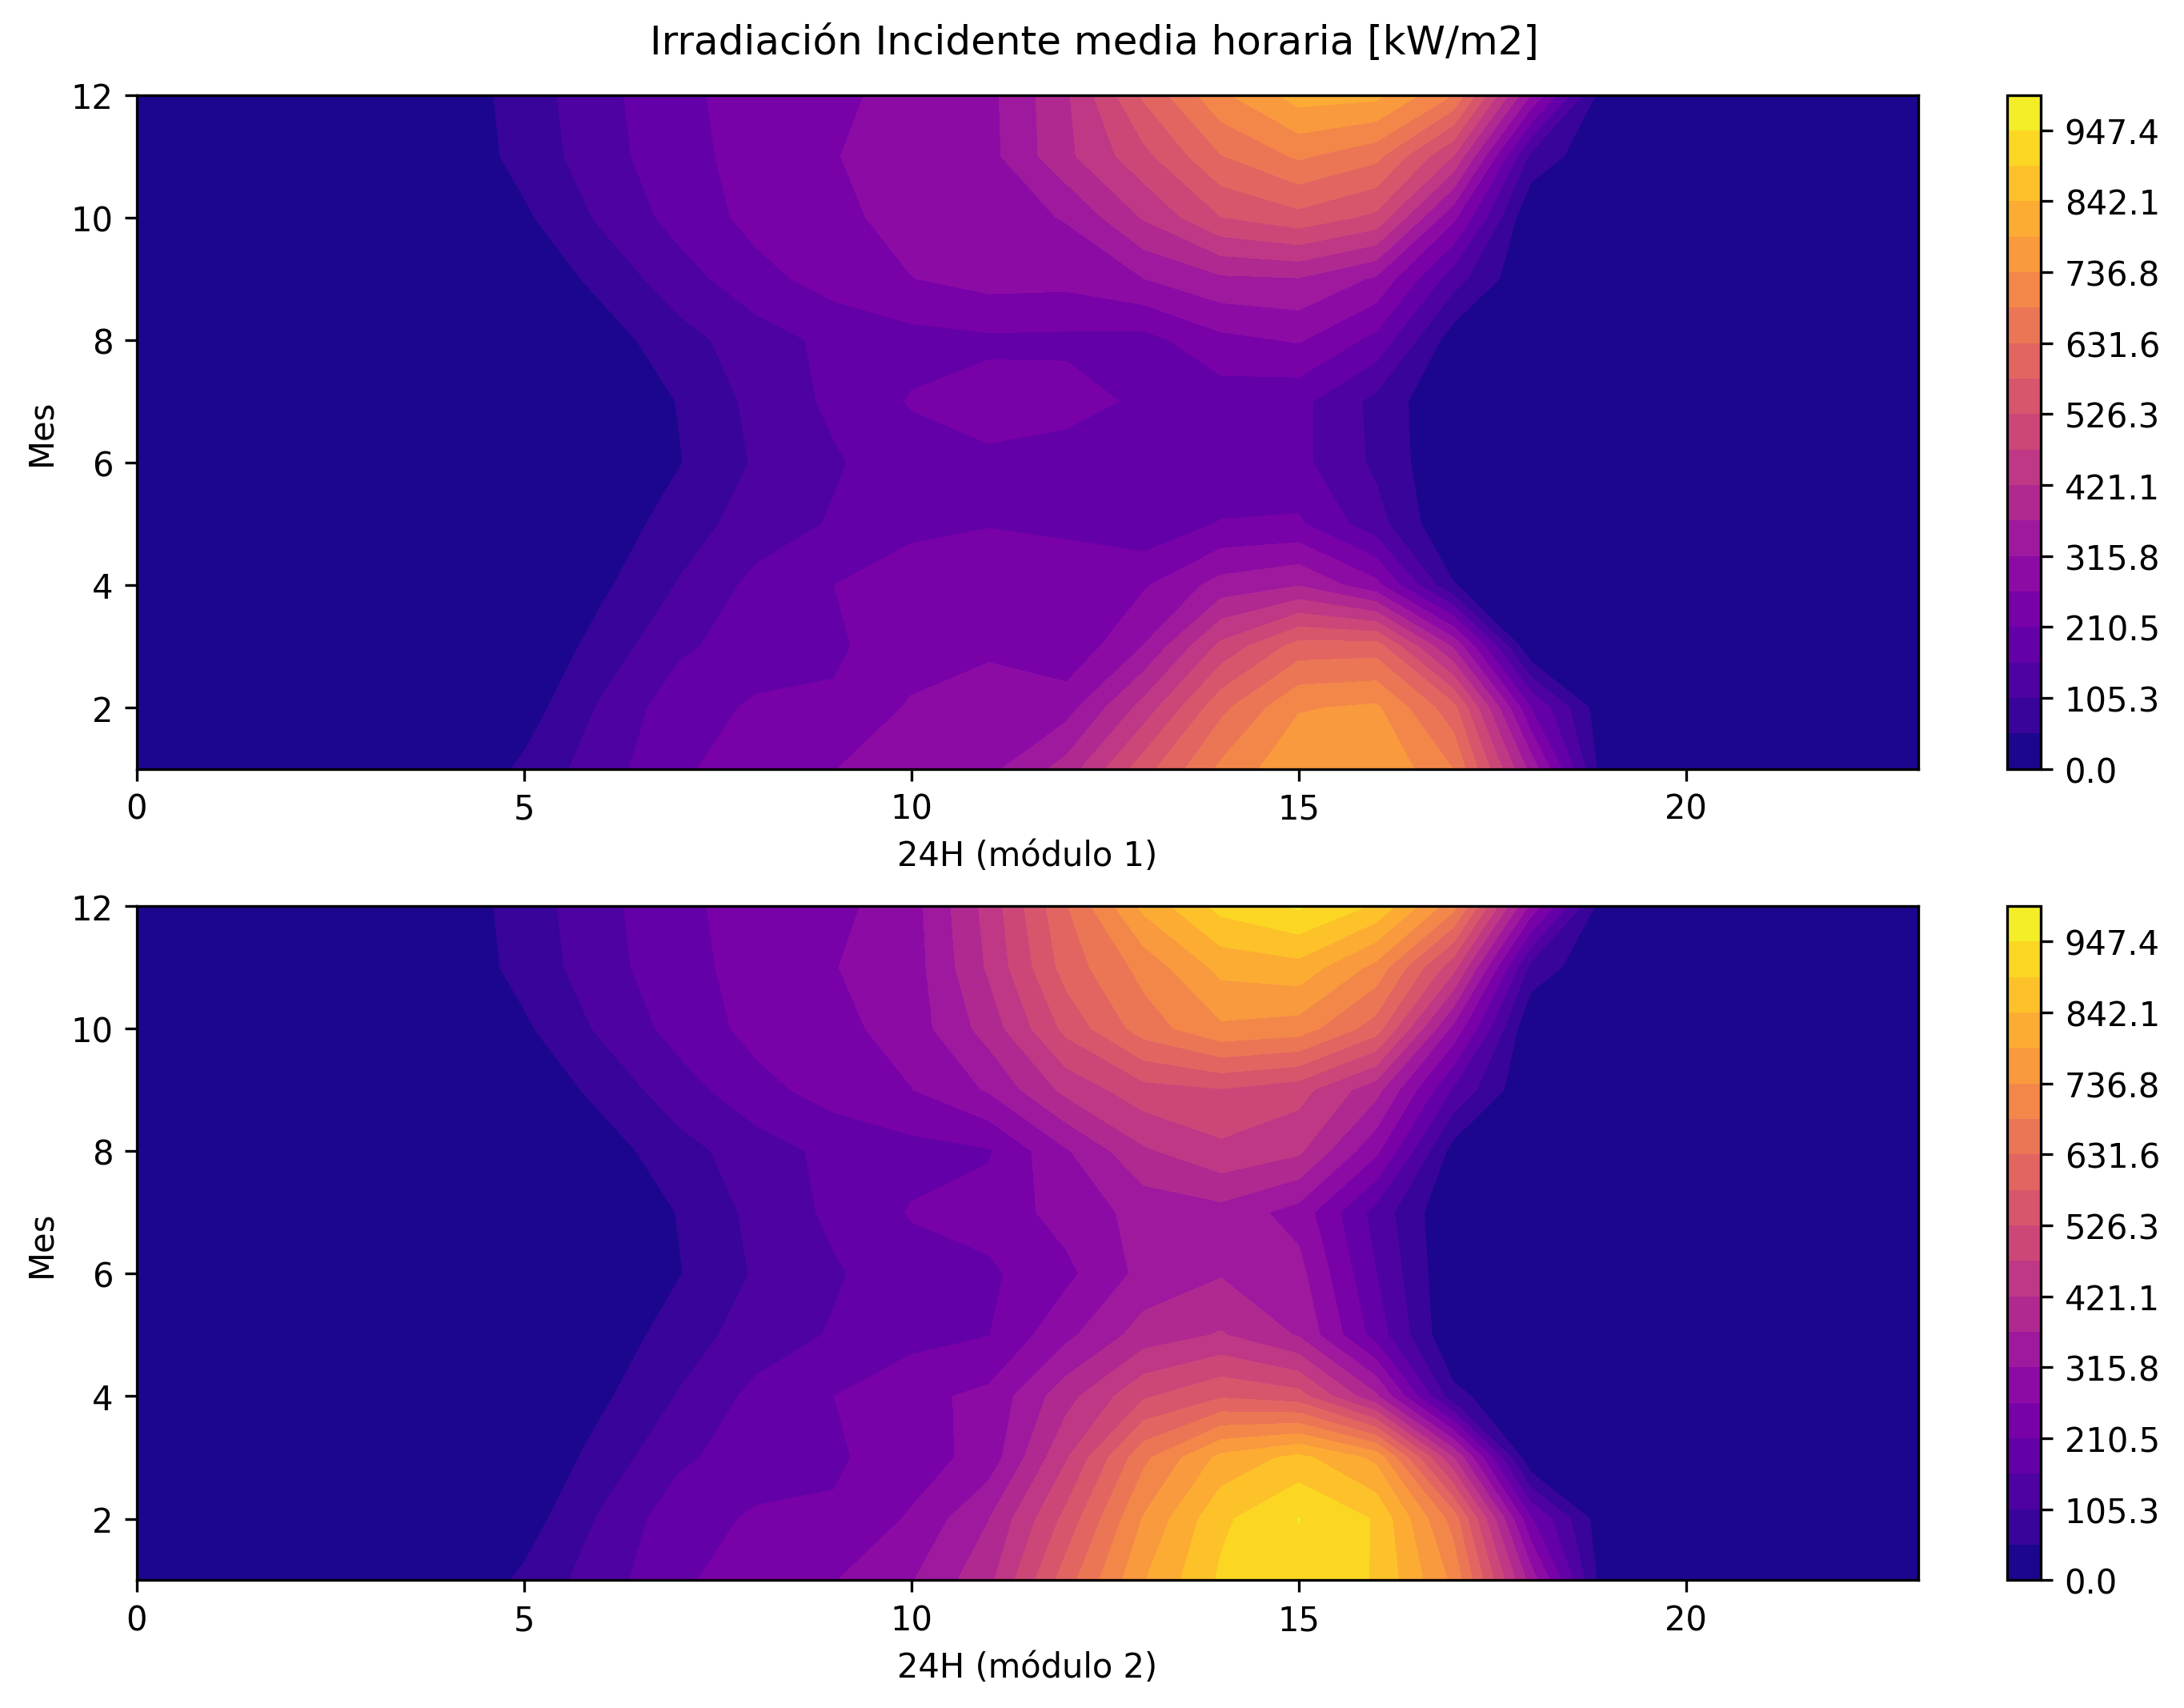

In [22]:
#plot_components_irr

modules = project.production_array()

fig,axs = plt.subplots(2,1,layout='constrained')
fig.dpi = 300
fig.set_size_inches(9,7)

for i,module in enumerate(modules):
    
    #pivot table
    pivot = module.fillna(0).pivot_table(index='month',columns='hour',values='IRR_incident')
    #meshgrid
    X,Y = np.meshgrid(pivot.columns,pivot.index)
    Z = pivot.values
    levels = np.linspace(0,1000,20)
    cs= axs[i].contourf(X,Y,Z,levels=levels,cmap='plasma')
    plt.colorbar(cs)
    
    axs[i].set_xlabel(f'24H (módulo {1+i})')
    axs[i].set_ylabel('Mes')

fig.suptitle('Irradiación Incidente media horaria [kW/m2]')
plt.savefig('build/plot_components_irr',dpi=305)

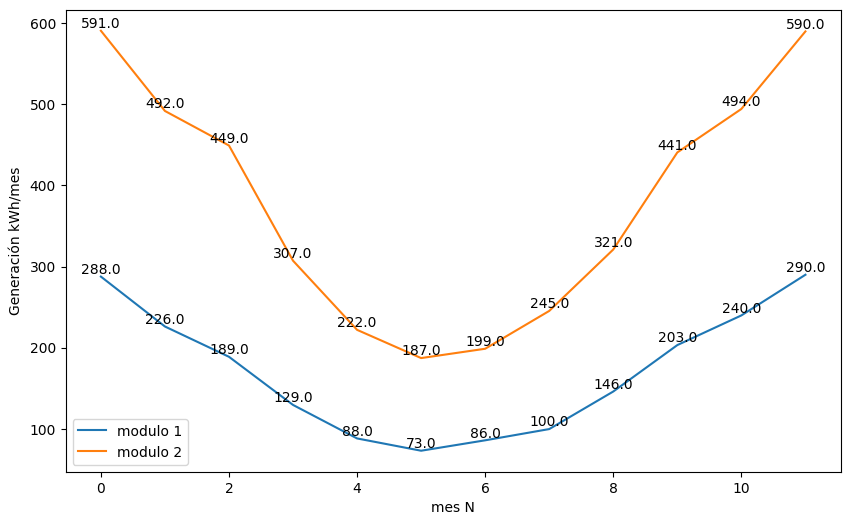

In [23]:
#plot_components_production
#source
modules = project.production_array()
#plotter
plt.figure(figsize=(10,6))
axs = plt.subplot()

for i,module in enumerate(modules):  
    #pivot table
    group = module[['month','day','System_capacity_KW']].groupby(['month'],as_index=False).sum()
    #meshgrid
    axs.plot(group.index,group['System_capacity_KW'],label=f'modulo {i+1}')
    axs.set_xlabel('mes N')
    axs.set_ylabel('Generación kWh/mes')
    
    for i, value in enumerate(group['System_capacity_KW'].round(0).values):
        plt.text(group.index[i], group['System_capacity_KW'][i], value, ha='center', va='bottom')
    
plt.legend()
plt.savefig(PATH+'plot_components_production'+'.png',dpi=300)

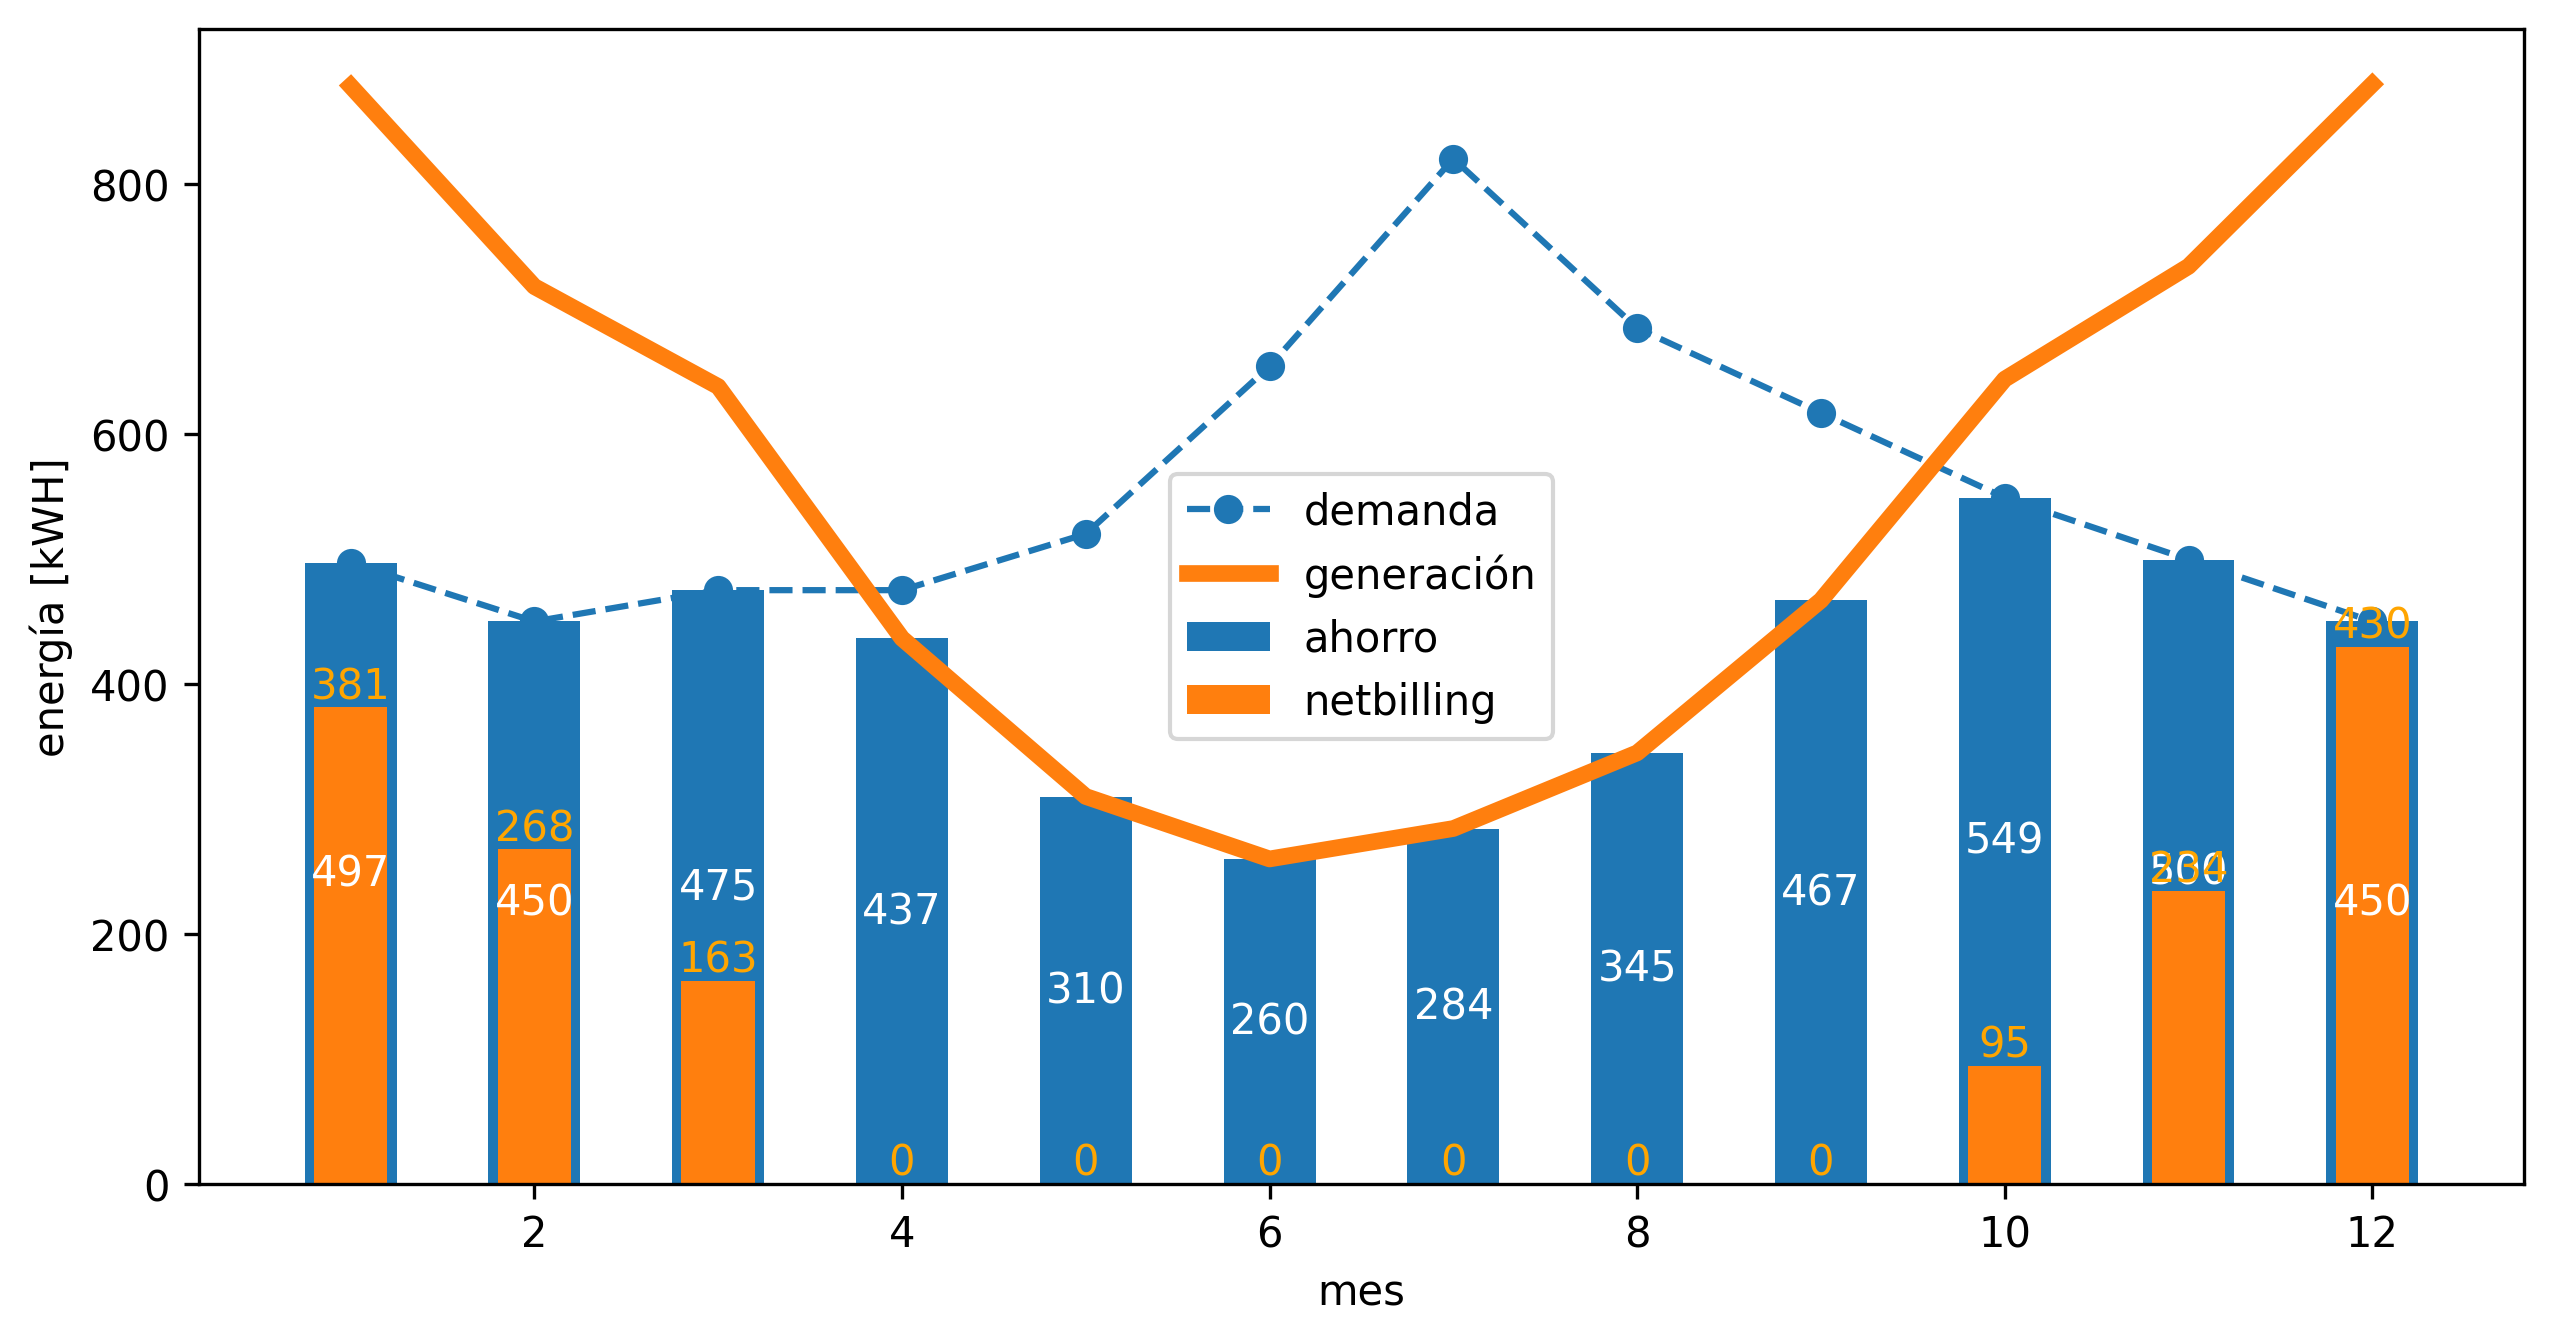

In [24]:
#plot_production_performance
plt.figure(figsize=(10,5),dpi=300)
p = plt.subplot()
x = production_performance['month']
p.plot(x,production_performance['consumption'],'o--',label='demanda')
p.plot(x,production_performance['generation'],label='generación',linewidth=4)
sv=p.bar(x,production_performance['savings'],label='ahorro',width=0.5)
nb= p.bar(x,production_performance['netbilling'],label='netbilling',width=0.4)
p.bar_label(sv,label_type='center',fmt='%.0f',color='w')
p.bar_label(nb,label_type='edge',fmt='%.0f', color='orange')

p.set_xlabel('mes'), p.set_ylabel('energía [kWH]')
plt.legend()
plt.savefig(PATH+'plot_production_performance'+'.png',dpi=300)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1920x1440 with 0 Axes>

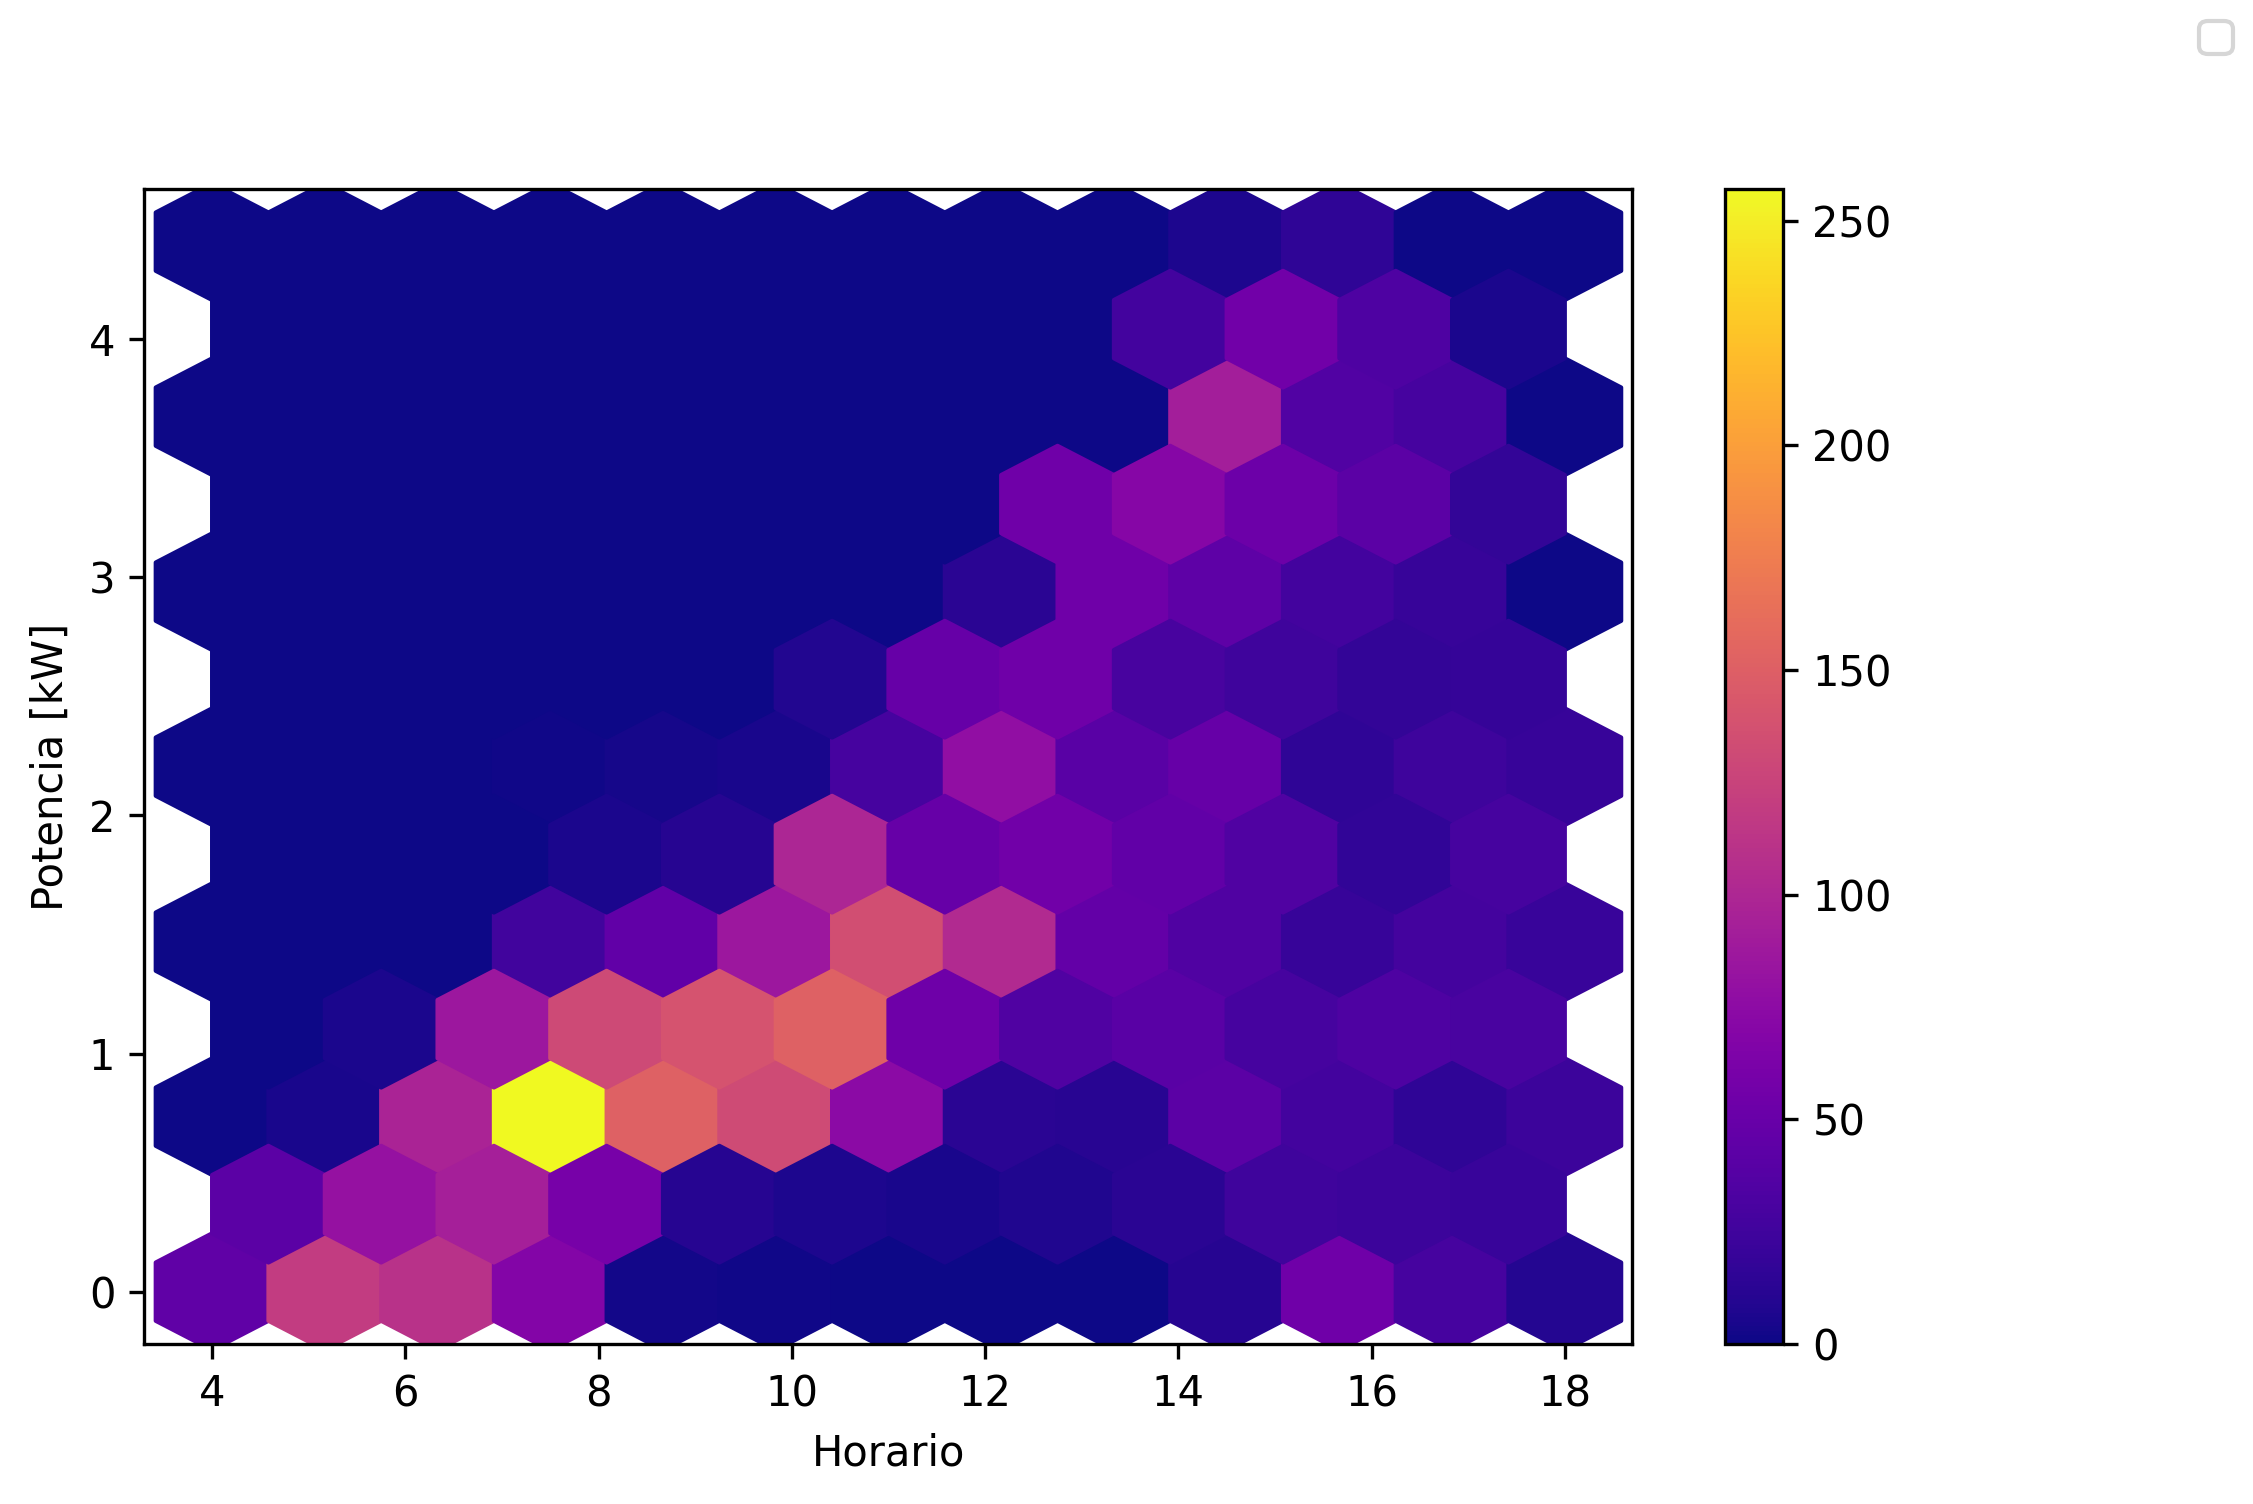

In [36]:
#plot_performance_frequency

plt.figure(dpi=300,layout='constrained')
fig,p = plt.subplots()
fig.set_size_inches(8,5)
fig.set_dpi(300)
x = project.energy_production()['hour']
y = project.energy_production()['System_capacity_KW']
hb = p.hexbin(x,y,gridsize=12,cmap='plasma')
plt.colorbar(hb)

p.set_xlabel('Horario'), p.set_ylabel('Potencia [kW]')
fig.legend()
plt.savefig(PATH+'plot_performance_frequency'+'.png',dpi=300)

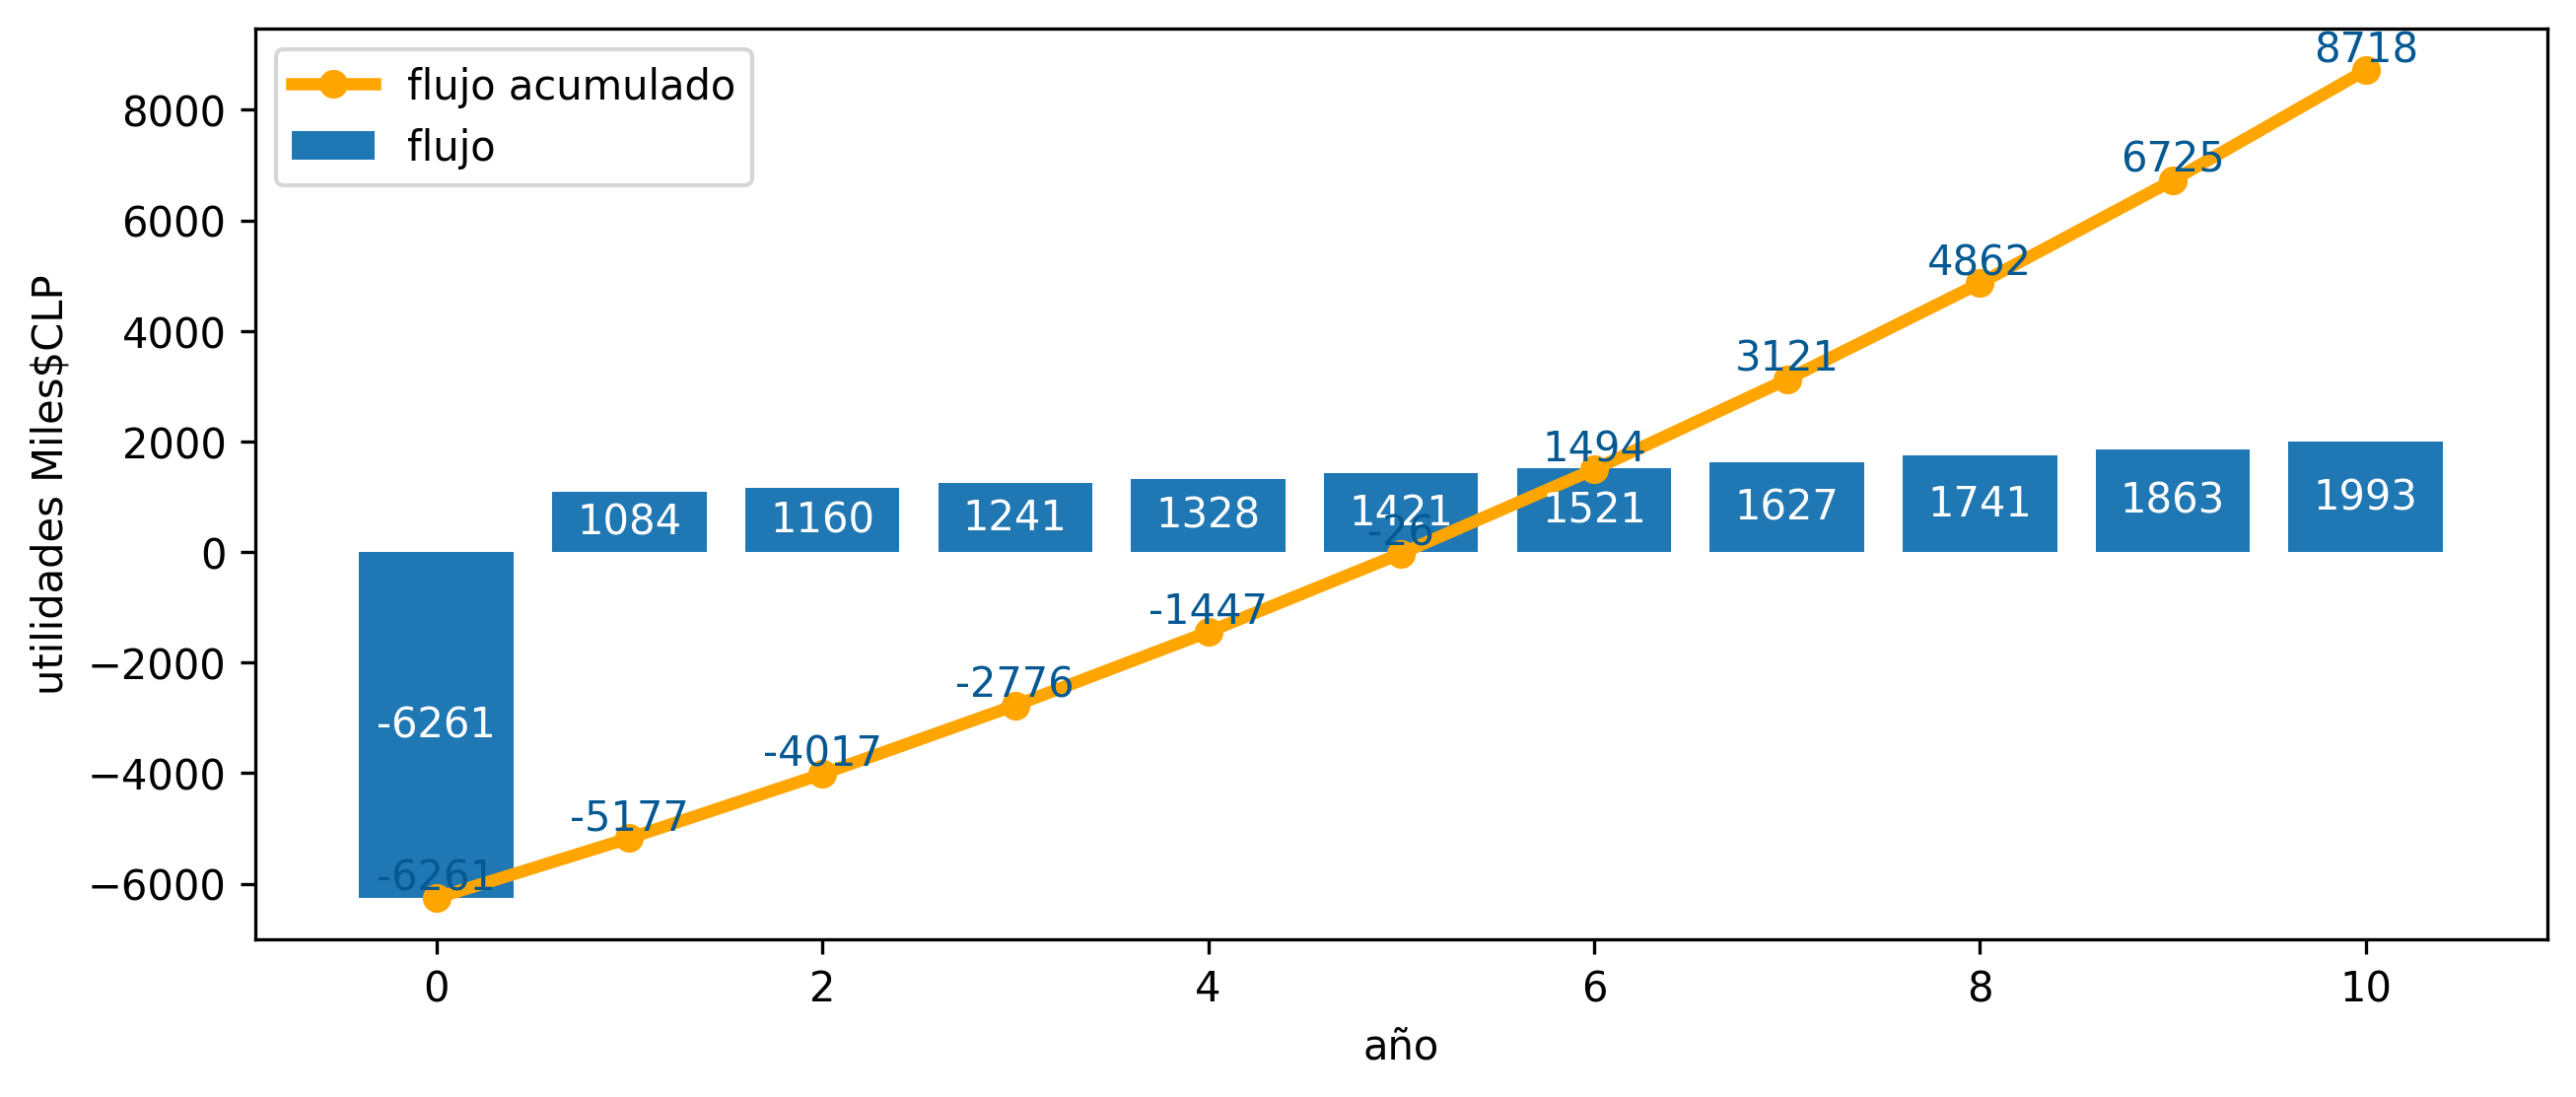

In [25]:
#plot_flux
#cspell: disable
plt.figure(figsize=(10,4),dpi=300)
data = DataFrame({"flujo":ctx['eco_num']['flux'],"acumulado":ctx['eco_num']['accumulated']})
p = plt.subplot()
bar=p.bar(data.index,data['flujo']/1000,width=.8,label='flujo')
line=p.plot(data.index,data['acumulado']/1000,color='orange',marker='o',linewidth=3,label='flujo acumulado')
p.bar_label(bar,label_type='center',fmt='%.0f',color='w')
p.set_xlabel('año'), p.set_ylabel('utilidades Miles$CLP',)

for i, value in enumerate(data['acumulado'].round(0).values):
    plt.text(data.index[i], (data['acumulado']/1000)[i], f'{value/1000:.0f}', ha='center', va='bottom',color='#045993',)
plt.legend()     
plt.savefig(PATH+'plot_flux'+'.png',dpi=300)

In [26]:
#set into doc
plot_list = [
    'plot_consumption_forecast',
    'plot_irradiance',
    'plot_temperature',
    'plot_components',
    'plot_components_irr',
    'plot_components_production',
    'plot_production_performance',
    'plot_performance_frequency',
    'plot_flux',
]

for plot in plot_list:
    doc.replace_pic(plot,f'build/{plot}.png')
    print('replaced plot:',plot)

replaced plot: plot_consumption_forecast
replaced plot: plot_irradiance
replaced plot: plot_temperature
replaced plot: plot_components
replaced plot: plot_components_irr
replaced plot: plot_components_production
replaced plot: plot_production_performance
replaced plot: plot_performance_frequency
replaced plot: plot_flux


In [27]:
doc.save(f"build/reporte_{project.building.city}_{project.building.name}.docx")